# **Getting them stonks: An introduction to Mean-Variance portfolio optimization**
---

## Contents:

>[1 - Introduction](#1---Introduction)
>
>[2 - Importing modules](#2---Importing-modules)
>
>[3 - Data retrieval](#3---Data-retrieval)
>
>[4 - Preprocessing](#4---Preprocessing)
>
>[5 - Modelling](#5---Modelling)
>
>[6 - Conclusion](#6---Conclusion)
>


## 1 - Introduction

1. Present aim
2. Explain Theory (mean-variance optimization)
3. Get data (summary stats)
4. Plot Efficient frontier + portfolio points (MC simulation)
5. Change parameters
6. Extensions

### **Scenario:** You won the lottery, recieved the paycheck for your summer internship, or that distant uncle you didn't even know passed and left you some money... what do you do?
### **A:** Invest... but how?

Recepie for investment:

1. Define a goal/strategy
2. Pick suitable assets
3. **Construct a suitable portfolio**
4. Check and repeat

### **Q:** Given $n$ assets, what is the optimal allocation of these within a portfolio?
### **A:** There are many...

### The Mean-Variance framework:
- Developed by Harry Markowitz in 1952 (earned him Nobel Price in Economics)
- Aims to solve the above problem using two ingredients:
    1. The volatility of asset returns (risk) - for stocks, this is the average log first difference in stock prices
    2. The expected asset returns (reward) - for stocks, this is the sample covariance of periodic returns
- Shortcomings:
    - Stock returns can be non-stationary $\implies$ we can't used average returns as a reasonable forecast
    - Stock returns are notoriously hard to forecast (Efficient Market Hypothesis)
    
### Goal: Using those two ingredients, find an set of weights for how much each asset should make up of the total portfolio
    

## 2 - Importing modules

In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns

# Declaring standard Seaborn color palette
standard_palette = []
for i in range(10):
    standard_palette += list(sns.color_palette('muted'))
import plotly
import cufflinks

from random import seed
from random import random

seed(1)
%matplotlib inline

## 3 - Data retrieval

First, we need to gather data on stock prices for a selection of assets. We focus our attention on [Investopedia's Top Stocks for March 2021](https://www.investopedia.com/top-stocks-4581225) during the period Feb 2018 - Feb 2021.

In [2]:
# Specify asset symbols
stocks = ['NRG','BIO','VIRT','WTM','ALL','MAT','FCX','IAC','ZM','CE','MRNA','PTON','ETSY','TSLA','ZS']
data = web.DataReader(stocks, 'yahoo', start='2019/02/10', end='2021/02/10')
data.head()

Attributes  Adj Close                                                \
Symbols           NRG         BIO       VIRT         WTM        ALL   
Date                                                                  
2019-02-11  40.368961  252.929993  23.600658  920.919434  88.779411   
2019-02-12  40.521839  258.100006  23.862984  913.227234  89.144028   
2019-02-13  40.655602  261.790009  23.763483  901.424561  90.189827   
2019-02-14  40.712940  261.420013  23.265959  898.381592  89.451050   
2019-02-15  40.569614  270.339996  22.858894  903.908752  90.554420   

Attributes                                                  ...      Volume  \
Symbols           MAT        FCX        IAC  ZM         CE  ...         MAT   
Date                                                        ...               
2019-02-11  15.740000  11.329431  72.540932 NaN  91.073799  ...  16303600.0   
2019-02-12  16.469999  11.290126  72.855270 NaN  94.205116  ...  15181600.0   
2019-02-13  17.070000  12.076210  72.514732 NaN  93.768631  ...  10584100.0   
2019-02-14  16.910000  11.948471  72.164375 NaN  94.451813  ...   6968400.0   
2019-02-15  13.820000  12.066383  72.043221 NaN  95.653938  ...  33526900.0   

Attributes                                                                   \
Symbols            FCX        IAC  ZM         CE       MRNA PTON       ETSY   
Date                                                                          
2019-02-11  15561600.0  3673962.0 NaN  1123000.0   597900.0  NaN  2122300.0   
2019-02-12  15617900.0  2423044.0 NaN  1511900.0   753100.0  NaN  2576600.0   
2019-02-13  36169400.0  1815298.0 NaN   811700.0  1333500.0  NaN  2073500.0   
2019-02-14  15313400.0  1884013.0 NaN   921500.0  1091400.0  NaN  1595400.0   
2019-02-15  16573400.0  1009958.0 NaN  1337400.0  2087400.0  NaN  2537500.0   

Attributes                         
Symbols           TSLA         ZS  
Date                               
2019-02-11  35648500.0  1122800.0  
2019-02-12  27588000.0  1493600.0  
2019-02-13  25708000.0  1194800.0  
2019-02-14  26004000.0  1315000.0  
2019-02-15  19524500.0  1018100.0  

[5 rows x 90 columns]

In [3]:
data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2019-02-11 to 2021-02-10
Columns: 90 entries, ('Adj Close', 'NRG') to ('Volume', 'ZS')
dtypes: float64(90)
memory usage: 359.0 KB


## 4 - Preprocessing

In [4]:
data = data['Adj Close']
data.head()

Symbols,NRG,BIO,VIRT,WTM,ALL,MAT,FCX,IAC,ZM,CE,MRNA,PTON,ETSY,TSLA,ZS
Date,,,,,,,,,,,,,,,
2019-02-11,40.368961,252.929993,23.600658,920.919434,88.779411,15.740000,11.329431,72.540932,NaN,91.073799,18.170000,NaN,53.150002,62.568001,48.590000
2019-02-12,40.521839,258.100006,23.862984,913.227234,89.144028,16.469999,11.290126,72.855270,NaN,94.205116,18.690001,NaN,55.830002,62.362000,50.099998
2019-02-13,40.655602,261.790009,23.763483,901.424561,90.189827,17.070000,12.076210,72.514732,NaN,93.768631,18.530001,NaN,55.040001,61.633999,49.000000
2019-02-14,40.712940,261.420013,23.265959,898.381592,89.451050,16.910000,11.948471,72.164375,NaN,94.451813,19.660000,NaN,54.060001,60.754002,50.080002
2019-02-15,40.569614,270.339996,22.858894,903.908752,90.554420,13.820000,12.066383,72.043221,NaN,95.653938,21.440001,NaN,54.660000,61.576000,50.110001


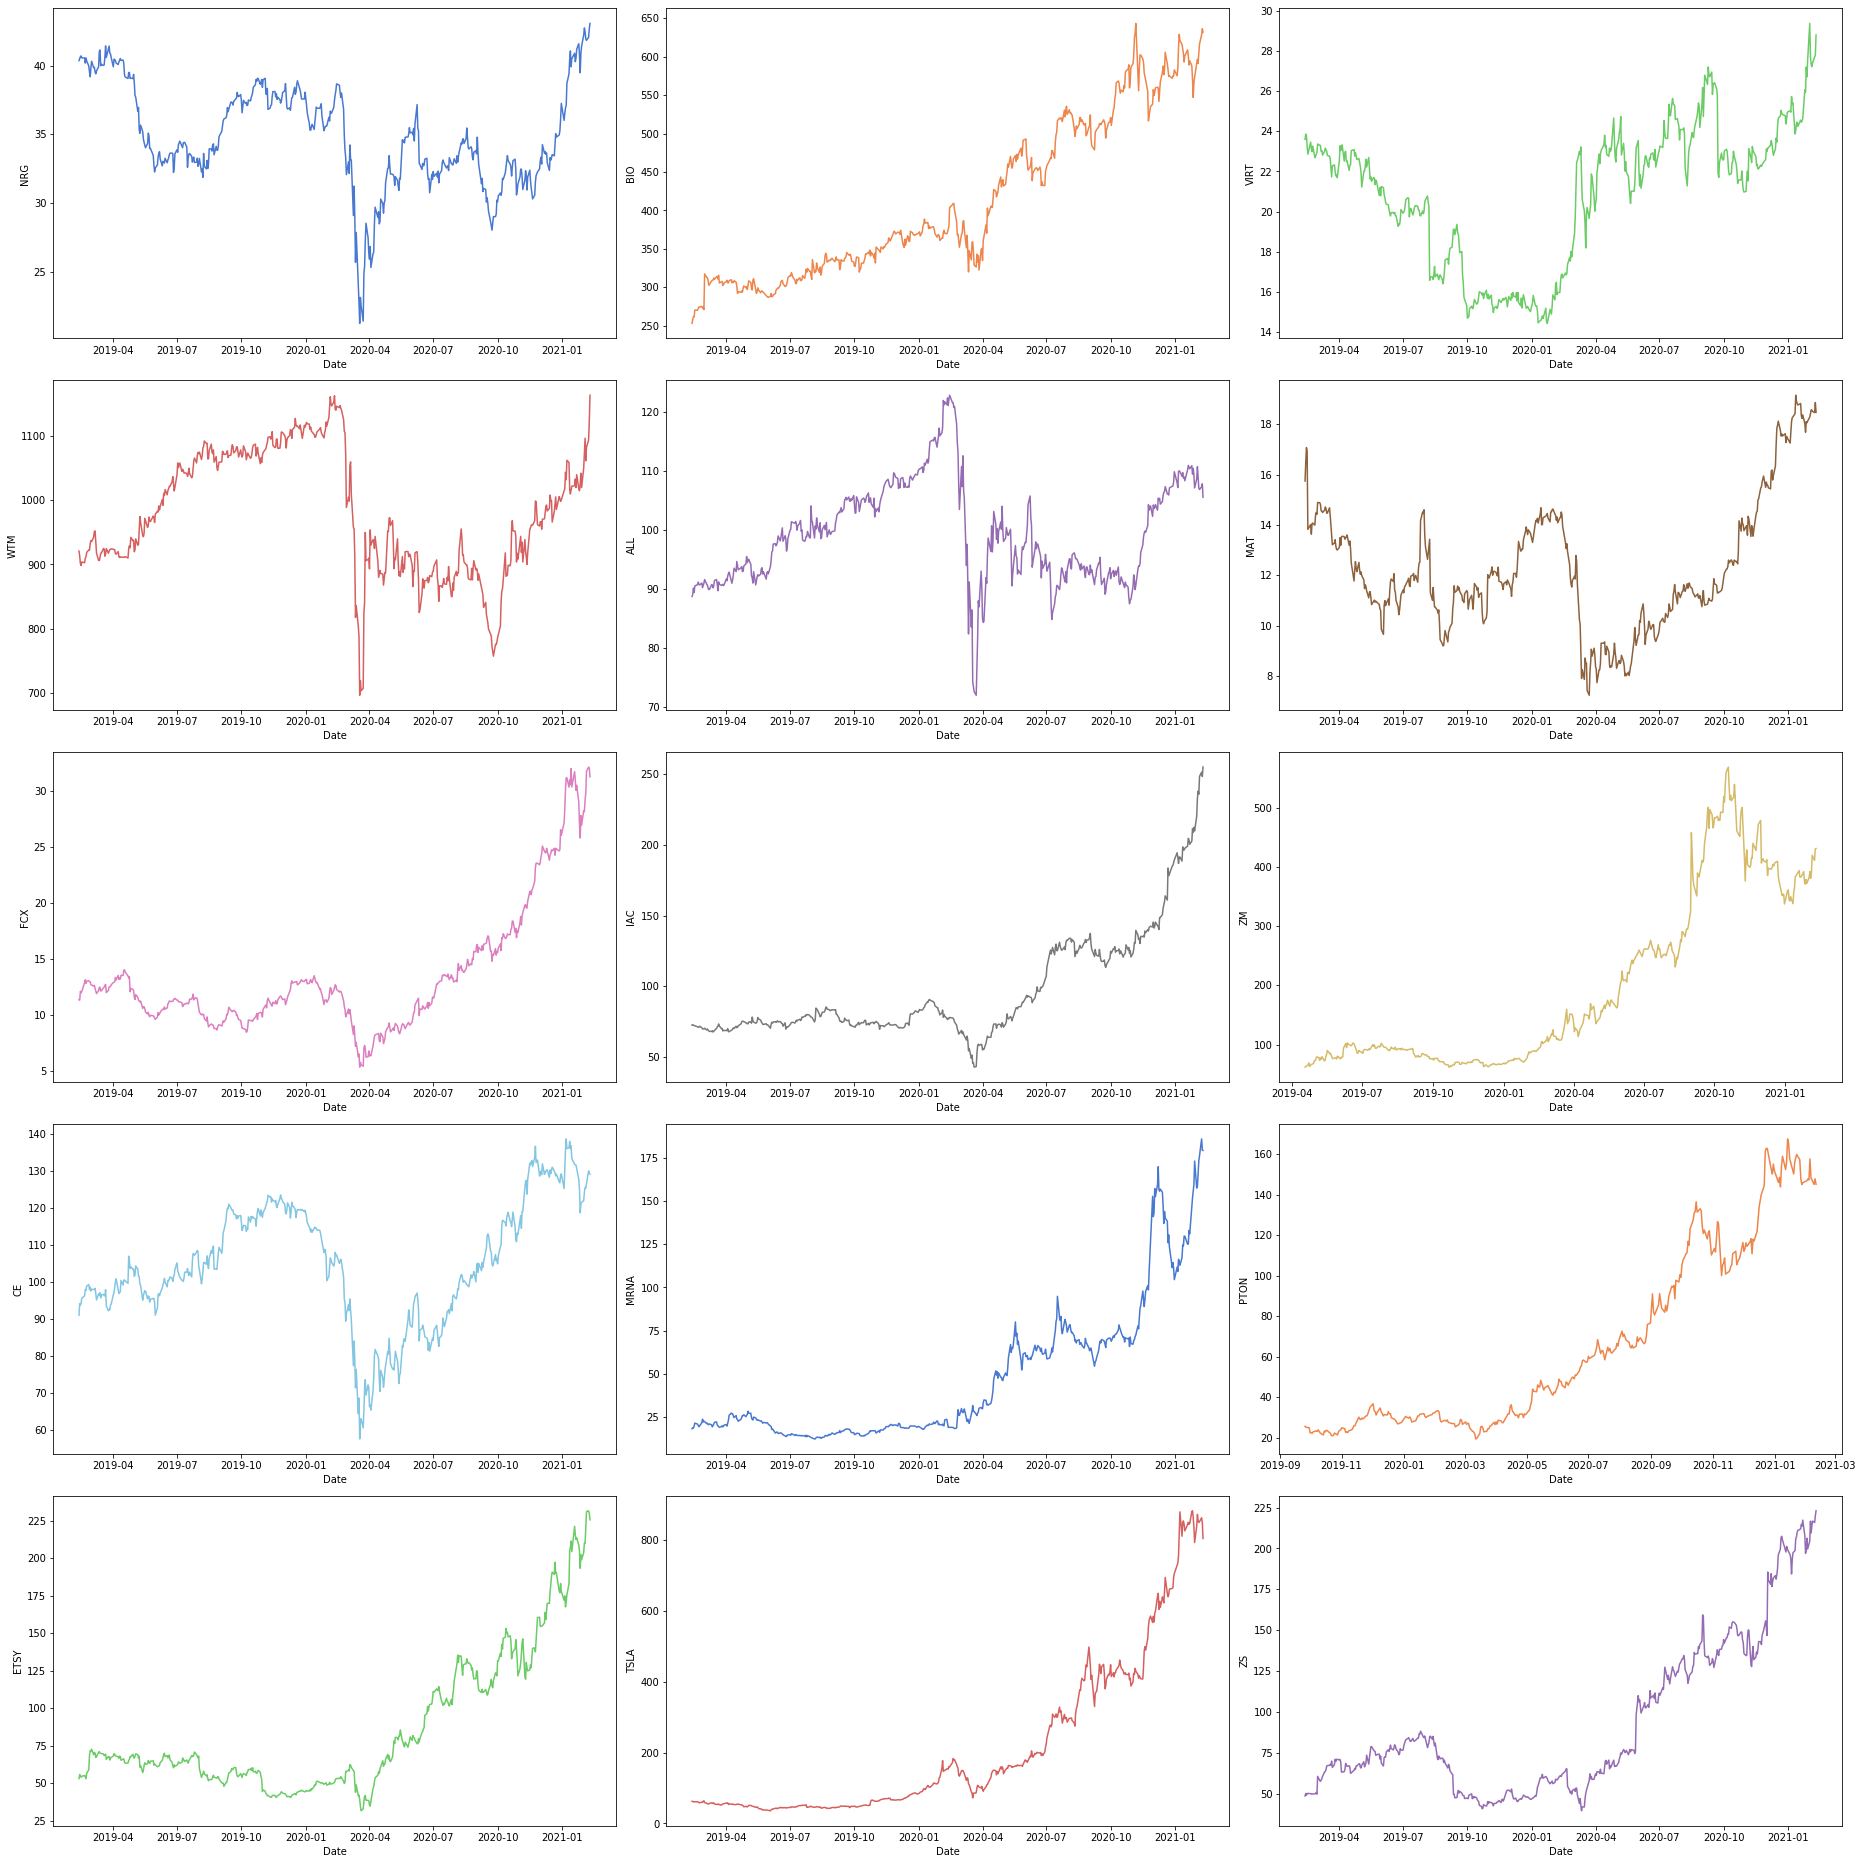

In [22]:
fig, axs = plt.subplots(5,3)
fig.set_size_inches(26, 26)
for i in range(15):
    sns.lineplot(data=data.iloc[:, i].dropna(), 
                ax=axs[i//3, i % 3],
                color=standard_palette[i])

plt.tight_layout()

In [6]:
returns = (np.log(data)).diff()
returns.info(verbose=False)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2019-02-11 to 2021-02-10
Columns: 15 entries, NRG to ZS
dtypes: float64(15)
memory usage: 63.1 KB


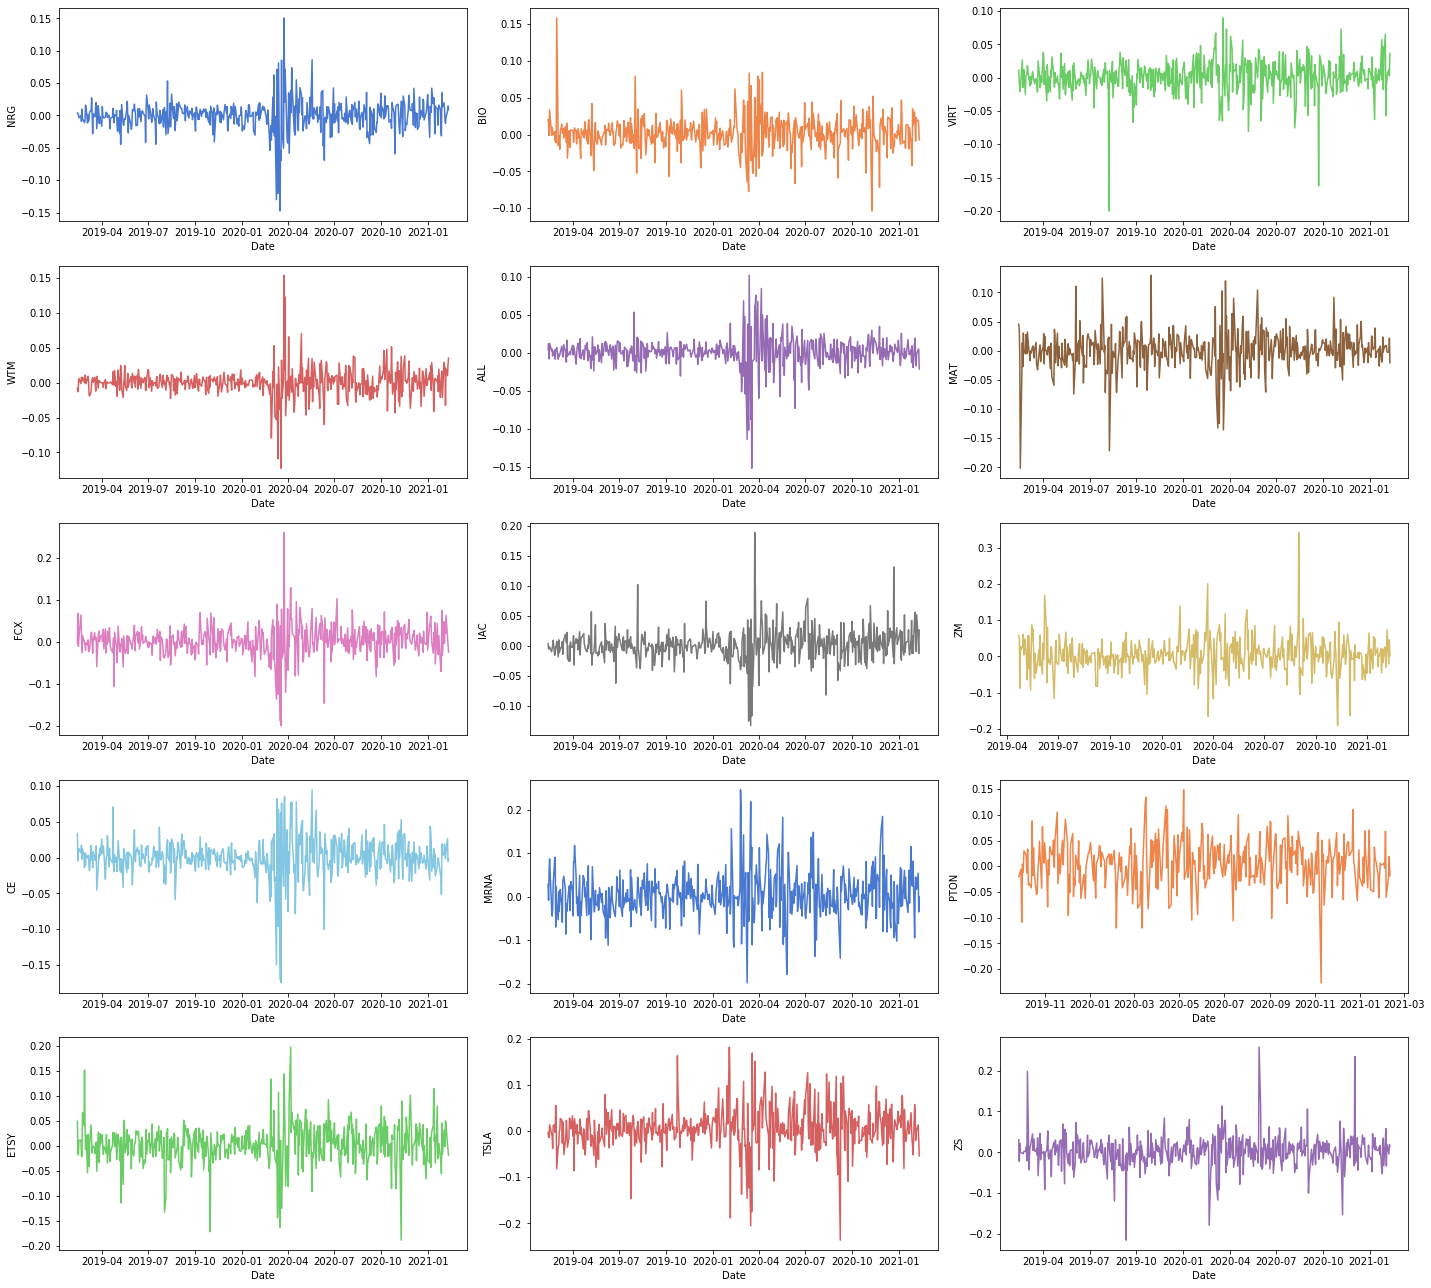

In [21]:
fig, axs = plt.subplots(5,3)
fig.set_size_inches(20, 18)
for i in range(15):
    sns.lineplot(data=returns.iloc[:, i].dropna(), 
                ax=axs[i//3, i % 3],
                color=standard_palette[i])
    
plt.tight_layout()

NameError: name 'py' is not defined

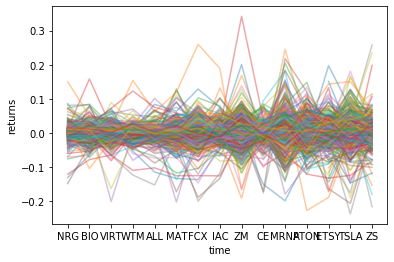

In [23]:
fig = plt.figure()
plt.plot(returns.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')
py.iplot_mpl(fig, filename='s6_damped_oscillation')

In [14]:
ex_returns = returns.mean()
cov_returns = returns.cov()

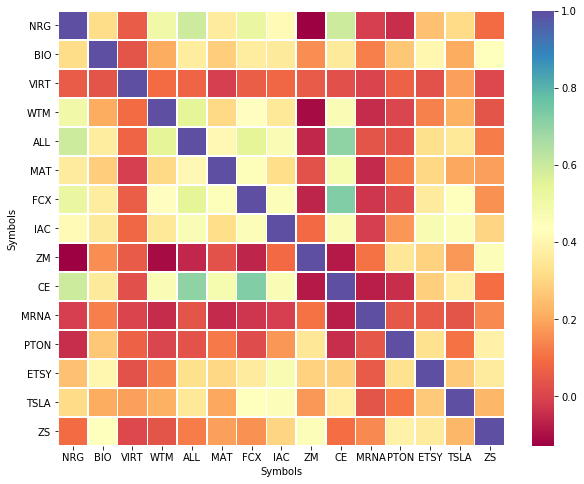

In [18]:
# Calculating correlation matrix of returns
corr_returns = returns.corr()
f, axs = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_returns, cmap="Spectral", linewidths=0.5, ax=axs)
plt.show()

## 5 - Modelling

#### Goal:

$W=\begin{bmatrix}
w_1\\
\vdots \\
w_n
\end{bmatrix}$

#### Ingredients:

#### $R=\begin{bmatrix}
\mathbb{E}[r_1]\\
\vdots \\
\mathbb{E}[r_n]
\end{bmatrix} \quad,\quad\Sigma = \begin{bmatrix}
\sigma_{11} & \dots & \sigma_{n1}\\
\vdots & \ddots & \vdots\\
\sigma_{1n} & \dots & \sigma_{nn}
\end{bmatrix}$

#### Plan of Attack:
1. Define our objective function
2. OPTIMIZE!
3. Analyze solutions

### Model 1: Minimum volatility

#### $ \underset{W}{\text{min}} \quad  W^T\:\Sigma \: W$
#### $\textrm{s.t}\quad \sum_{i=1}^{n}{w_i}=1 \quad , \quad w_i\geq 0$


In [9]:
# Defining weights vector
n = 15
w = cp.Variable(n)

# Creating objective function and constraints
objective = cp.quad_form(w, cov_returns)
constraints = [w>=0,                    # no short-selling constraint
               (np.ones(n))@w == 1]     # market-neutral constraint

# Solving for optimal portfolio
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

# Print result
print("\nThe optimal value is", problem.value)
print("Solution weight is")
print(w.value)



The optimal value is 0.00017136909014776135
Solution weight is
[ 8.49615851e-02  1.42537835e-01  2.22169841e-01  2.69214269e-01
  9.65469072e-02  3.04480010e-02  1.26720786e-19  1.22976629e-02
  6.96358708e-02  2.41514156e-19  5.22182620e-02  1.99697658e-02
  2.94787475e-19  3.58344219e-19 -4.81091531e-20]


### Model 2: Minimum volatility (with short-selling)

#### $ \underset{W}{\text{min}} \quad  W^T\:\Sigma \: W$
#### $\textrm{s.t}\quad \sum_{i=1}^{n}{w_i}=1$


In [10]:
# Defining weights vector
n = cov_returns.shape[0]
w = cp.Variable(n)

# Creating objective function and constraints
objective = cp.quad_form(w, cov_returns)
constraints = [(np.ones(n))@w == 1]     # market-neutral constraint

# Solving for optimal portfolio
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

# Print result
print("\nThe optimal value is", problem.value)
print("Solution weight is")
print(w.value)


The optimal value is 0.00016278583064735679
Solution weight is
[ 0.10202328  0.15087124  0.22238932  0.25970357  0.09918921  0.0406073
 -0.08239544  0.05418394  0.07445563  0.06639012  0.05171331  0.0235354
 -0.02464992 -0.03603957 -0.00197738]


### Model 3: Risk-efficient

#### $ \underset{W}{\text{min}} \quad  W^T\:\Sigma \: W $
#### $\textrm{s.t}\quad R^T\!W = \mu \quad , \quad \sum_{i=1}^{n}{w_i}=1\quad , \quad w_i\geq 0$

In [11]:
# Defining weights vector
n = 15
w = cp.Variable(n)

# Defining target return rate in (0,0.25]
mu = (random())/4

# Creating objective function and constraints
objective = cp.quad_form(w, cov_returns)
constraints = [(ex_returns.to_numpy())@w == mu,      # target return constraint
               (np.ones(n))@w == 1]     # market-neutral constraint

# Solving for optimal portfolio
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

# Print result
print('Target return rate: ', mu)
print("\nThe optimal value is", problem.value)
print("Solution weight is")
print(w.value)

Target return rate:  0.033591061028100305

The optimal value is 0.036746441157617354
Solution weight is
[-2.0575882   0.91665198 -1.78800867  0.03466621 -3.80076204 -1.17486166
  1.45170606  2.15955103  0.67495603  0.13645673  1.42094763  1.70051905
 -0.13239472  2.11195467 -0.65379409]


### Model 4: Return-efficient

#### $ \underset{W}{\text{max}} \quad R^T\!W$
#### $\textrm{s.t}\quad W^T\:\Sigma \: W = \sigma^2 \quad , \quad \sum_{i=1}^{n}{w_i}=1 \quad , \quad w_i\geq 0$

In [12]:
# Defining weights vector
n = 15
w = cp.Variable(n)

# Defining target volatility in (0,0.1]
mu = (random())/10

# Creating objective function and constraints
objective = cp.quad_form(w, cov_returns)
constraints = [(ex_returns.to_numpy())@w == mu,      # target return constraint
               (np.ones(n))@w == 1]     # market-neutral constraint

# Solving for optimal portfolio
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

# Print result
print('target risk: ', mu)
print("\nThe optimal value is", problem.value)
print("Solution weight is")
print(w.value)

target risk:  0.08474337369372327

The optimal value is 0.24140930816465844
Solution weight is
[-5.44375638  2.11735978 -4.94021717 -0.31818167 -9.91570026 -3.08065924
  3.8571043   5.46066657  1.61651211  0.24631785  3.56784199  4.32994972
 -0.30133344  5.47990756 -1.67581172]


### Model 5: Maximum Sharpe Ratio *
#### $ \underset{W}{\text{max}} \frac{R^T\!W - r_f}{\sqrt{W^T\:\Sigma \: W}}$
#### $\textrm{s.t}\quad \sum_{i=1}^{n}{w_i}=1 \quad , \quad w_i\geq 0$


## 6 - Conclusion


## 7 - References
